# Data Acquiring

In [2]:
import zipfile
with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
import os
data_dir = "Alzheimer_s Dataset"
print(os.listdir(data_dir))

['test', 'train']


In [4]:
data_dir += "/train"
print(os.listdir(data_dir))
#C:/Users/acayt/Documents/GitHub/Brain-MRI-Alzheimers-Prediction/Alzheimer_s Dataset/train

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


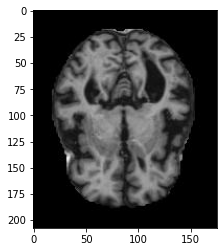

In [5]:
temp_dir = data_dir + "/MildDemented"

import cv2
import matplotlib.pyplot as plt

for img in os.listdir(temp_dir):
    img_array = cv2.imread(os.path.join(temp_dir, img))
    #print(img_array)
    plt.imshow(img_array)
    plt.show()
    break

In [6]:
print(img_array.shape)

(208, 176, 3)


# Data Preprocessing

In [7]:
import tensorflow as tf

In [8]:
# to augment images and create more samples

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.8, 1.2], zoom_range=[0.99, 1.01], horizontal_flip=True, fill_mode="constant", data_format="channels_last")

In [9]:
train_data_gen = image_generator.flow_from_directory(directory=data_dir, target_size=(176, 176), batch_size=6500, shuffle=False)

Found 5121 images belonging to 4 classes.


In [10]:
import numpy as np
from random import randint

In [11]:
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

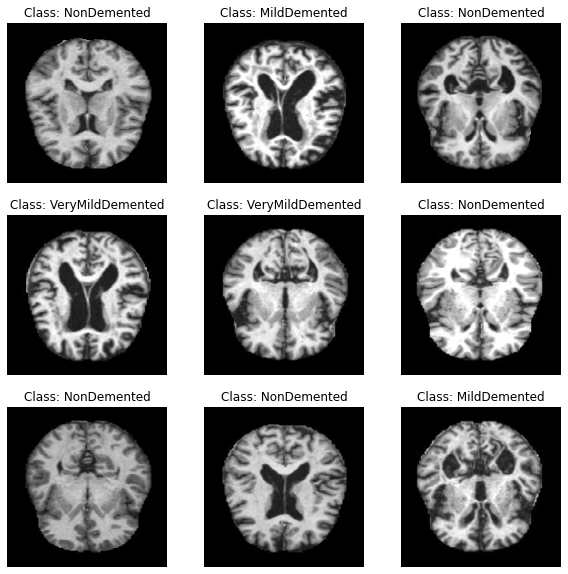

In [12]:
def show_images(generator,y_pred=None):
    #Input: An image generator, predicted labels (optional)
    #Output: Displays a grid of 9 random images with lables
        
    #get image lables
    labels =dict(zip([0,1,2,3], classes))
    
    #get a batch of images
    x,y = generator.next()
    
    #display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 5121) #because there are a total of 5121 images
            plt.imshow(x[idx].astype('uint8')) #This is done because of the reason that if the color intensity is a float,
            #then matplotlib expects it to range from 0 to 1. If an int, then it expects 0 to 255.
            #So we can either force all the numbers to int or scale them all by 1/255 or use the .astype function to cast the object onto our specified dtype.
            plt.axis("off")
            plt.title("Class: {}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i].astype('uint8'))
            plt.axis("off")
            plt.title("Actual: {} \nPredicted: {}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [13]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [14]:
for alzheimers_class in classes:
    container = []
    temp_dir = data_dir + "/" + alzheimers_class
    for file in os.listdir(temp_dir):
        container.append(file)
    print(alzheimers_class, ": ", len(container))

MildDemented :  717
ModerateDemented :  52
NonDemented :  2560
VeryMildDemented :  1792


The number of data samples for 'ModerateDemented' is considerably low, compared to the other classes. A clear contrast between the sizes of the training classes shows how imbalanced our classes are. So we'll need to perform over-sampling of the data using SMOTE.

In [15]:
import imblearn

sm = imblearn.over_sampling.SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176, 176, 3)
print(train_data.shape, train_labels.shape)

(10240, 176, 176, 3) (10240, 4)


# Model Training

Going to use multiple types of blocks, multiple times. So I'm just going to define functions for each type of blocks and call them later.

### Convolutional Blocks

In [16]:
def conv_block(filters, act='relu'):    
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters, 3, activation=act, padding='same'))
    block.add(tf.keras.layers.Conv2D(filters, 3, activation=act, padding='same'))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.MaxPool2D())
    
    return block

### Normalization Blocks

In [17]:
def norm_block(units, dropout_rate, act='relu'):    
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Dense(units, activation=act))
    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.Dropout(dropout_rate))
    
    return block

### Sequential Model

In [18]:
def construct_model(act='relu'):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*[176, 176], 3)),
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        norm_block(512, 0.7),
        norm_block(128, 0.5),
        norm_block(64, 0.3),
        tf.keras.layers.Dense(4, activation='softmax') #Output Layer       
    ], name = "cnn_model")

    return model

### Model Compilation

In [19]:
model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 176, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 16)       0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 44, 44, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 22, 22, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 11, 11, 128)       221952    
                                                         

### Model Training

In [20]:
history = model.fit(train_data, train_labels, epochs=50, validation_split=0.2)

Epoch 1/50
256/256 [==============================] - 452s 2s/step - loss: 1.6051 - acc: 0.3424 - auc: 0.6030 - val_loss: 1.6692 - val_acc: 0.3022 - val_auc: 0.5242
Epoch 2/50
256/256 [==============================] - 504s 2s/step - loss: 1.1336 - acc: 0.5037 - auc: 0.7660 - val_loss: 2.5475 - val_acc: 0.6240 - val_auc: 0.7251
Epoch 3/50
256/256 [==============================] - 468s 2s/step - loss: 0.8598 - acc: 0.6267 - auc: 0.8670 - val_loss: 0.8733 - val_acc: 0.6641 - val_auc: 0.9082
Epoch 4/50
256/256 [==============================] - 411s 2s/step - loss: 0.7100 - acc: 0.6876 - auc: 0.9096 - val_loss: 1.0207 - val_acc: 0.6978 - val_auc: 0.8318
Epoch 5/50
256/256 [==============================] - 359s 1s/step - loss: 0.6259 - acc: 0.7255 - auc: 0.9293 - val_loss: 6.6989 - val_acc: 0.0000e+00 - val_auc: 0.4050
Epoch 6/50
256/256 [==============================] - 365s 1s/step - loss: 0.5896 - acc: 0.7410 - auc: 0.9371 - val_loss: 1.1224 - val_acc: 0.5938 - val_auc: 0.8187
Epoch 

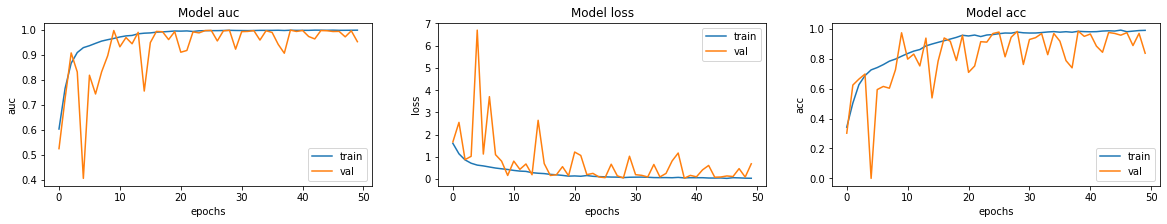

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss', 'acc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Model Testing

In [116]:
imvar = tf.keras.preprocessing.image.load_img('sample/26 (19).jpg').resize((176, 176))
imarr = tf.keras.preprocessing.image.img_to_array(imvar)

In [117]:
imarr = np.array([imarr])

In [118]:
imarr.shape

(1, 176, 176, 3)

In [94]:
test_data[0].shape

(176, 176, 3)

In [120]:
xyz = model.predict(imarr)

for xyzs in xyz:
    print(roundoff(xyzs))

[1. 0. 0. 0.]


In [22]:
data_dir1 = data_dir[:19]+'/test'
data_dir1

'Alzheimer_s Dataset/test'

In [23]:
test_data_gen = image_generator.flow_from_directory(directory=data_dir1, target_size=(176, 176), batch_size=6500, shuffle=False)

Found 1279 images belonging to 4 classes.


In [24]:
test_data, test_labels = test_data_gen.next()
print(test_data.shape, test_labels.shape)

(1279, 176, 176, 3) (1279, 4)


In [25]:
test_scores = model.evaluate(test_data, test_labels)
test_scores

40/40 [==============================] - 12s 279ms/step - loss: 2.2850 - acc: 0.5012 - auc: 0.7562


[2.2850327491760254, 0.5011727809906006, 0.7561625242233276]

In [26]:
predicted_test_labels = model.predict(test_data)

In [27]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in predicted_test_labels:
    labels = roundoff(labels)

In [28]:
import sklearn

print(sklearn.metrics.classification_report(test_labels, predicted_test_labels, target_names=classes))

                  precision    recall  f1-score   support

    MildDemented       0.27      0.87      0.41       179
ModerateDemented       0.38      0.25      0.30        12
     NonDemented       0.82      0.47      0.60       640
VeryMildDemented       0.57      0.41      0.47       448

       micro avg       0.50      0.50      0.50      1279
       macro avg       0.51      0.50      0.44      1279
    weighted avg       0.65      0.50      0.52      1279
     samples avg       0.50      0.50      0.50      1279



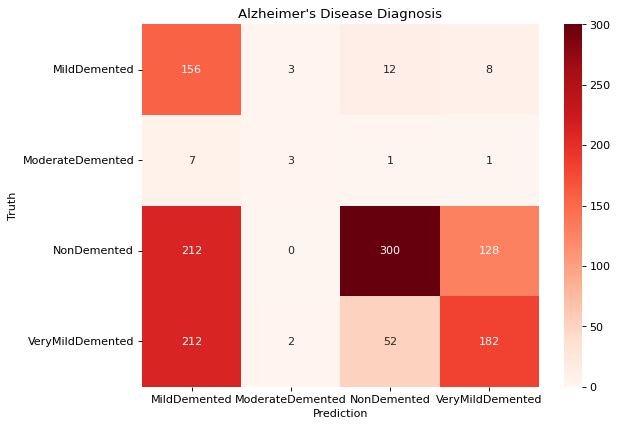

In [29]:
pred_ls = np.argmax(predicted_test_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = sklearn.metrics.confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

import seaborn as sns
ax = sns.heatmap(conf_arr, cmap='Reds', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [34]:
model.save("model")

INFO:tensorflow:Assets written to: model\assets


In [36]:
model2 = tf.keras.models.load_model("model")
model2